## Exercise 2
**Prediction task is to determine whether a person makes over 50K a year.**

 **fnlwgt column definition**: 

The weights on the CPS files are controlled to independent estimates of the civilian noninstitutional population of the US.  These are prepared monthly for us by Population Division here at the Census Bureau.  We use 3 sets of controls. These are:
   1.  A single cell estimate of the population 16+ for each state.
   2.  Controls for Hispanic Origin by age and sex.
   3.  Controls by Race, age and sex.

We use all three sets of controls in our weighting program and "rake" through them 6 times so that by the end we come back to all the controls we used.

The term estimate refers to population totals derived from CPS by creating "weighted tallies" of any specified socio-economic characteristics of the population.

People with similar demographic characteristics should have similar weights.  There is one important caveat to remember about this statement.  That is that since the CPS sample is actually a collection of 51 state samples, each with its own probability of selection, the statement only applies within state.

For any further information about this dataset: https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names

#### IMPORTING NECESSARY LIBRARIES

In [104]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
from mpl_toolkits.mplot3d import Axes3D

from sklearn.model_selection import train_test_split

from sklearn import preprocessing
from sklearn.decomposition import PCA

from sklearn.neighbors import KNeighborsClassifier
from sklearn import linear_model
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier

import sklearn.metrics as metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn import tree
from subprocess import call

#### LOADING, LOOKING AND WRANGLING DATA

In [2]:
train_data = pd.read_csv('Dataset/adult.data', header=None, na_values = ' ?')
test_data = pd.read_csv('Dataset/adult_test.data', header=None, na_values = ' ?')
df = pd.concat([train_data, test_data]) # We have concated both subsets because it was splitted before and I'd like to use as part of the exercise

df.columns = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'salary']

print(df.shape)
print(df.dtypes)
df.head(10)

(48842, 15)
age                int64
workclass         object
fnlwgt             int64
education         object
education-num      int64
marital-status    object
occupation        object
relationship      object
race              object
sex               object
capital-gain       int64
capital-loss       int64
hours-per-week     int64
native-country    object
salary            object
dtype: object


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
5,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K
6,49,Private,160187,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Jamaica,<=50K
7,52,Self-emp-not-inc,209642,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,>50K
8,31,Private,45781,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Female,14084,0,50,United-States,>50K
9,42,Private,159449,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178,0,40,United-States,>50K


In [3]:
# Looking for any NaN, missing or strange values:

print(df.age.unique())
print(df.workclass.unique())
print(df.fnlwgt.unique())
print(df.education.unique())
print(df['education-num'].unique())
print(df['marital-status'].unique())
print(df.occupation.unique())
print(df.relationship.unique())
print(df.race.unique())
print(df.sex.unique())
print(df['capital-gain'].unique())
print(df['capital-loss'].unique())
print(df['hours-per-week'].unique())
print(df['native-country'].unique())
print(df.salary.unique())

# After doing this we realized that missing values where named as ' ?' and not '?' as we thought at first.
# We changed the loading code to filter na_values.

[39 50 38 53 28 37 49 52 31 42 30 23 32 40 34 25 43 54 35 59 56 19 20 45 22
 48 21 24 57 44 41 29 18 47 46 36 79 27 67 33 76 17 55 61 70 64 71 68 66 51
 58 26 60 90 75 65 77 62 63 80 72 74 69 73 81 78 88 82 83 84 85 86 87 89]
[' State-gov' ' Self-emp-not-inc' ' Private' ' Federal-gov' ' Local-gov'
 nan ' Self-emp-inc' ' Without-pay' ' Never-worked']
[ 77516  83311 215646 ..., 173449  89686 350977]
[' Bachelors' ' HS-grad' ' 11th' ' Masters' ' 9th' ' Some-college'
 ' Assoc-acdm' ' Assoc-voc' ' 7th-8th' ' Doctorate' ' Prof-school'
 ' 5th-6th' ' 10th' ' 1st-4th' ' Preschool' ' 12th']
[13  9  7 14  5 10 12 11  4 16 15  3  6  2  1  8]
[' Never-married' ' Married-civ-spouse' ' Divorced'
 ' Married-spouse-absent' ' Separated' ' Married-AF-spouse' ' Widowed']
[' Adm-clerical' ' Exec-managerial' ' Handlers-cleaners' ' Prof-specialty'
 ' Other-service' ' Sales' ' Craft-repair' ' Transport-moving'
 ' Farming-fishing' ' Machine-op-inspct' ' Tech-support' nan
 ' Protective-serv' ' Armed-Forces' ' P

In [4]:
# CLEANING NaN and duplicates values
print(df.isnull().sum()) # We want to know where are those NaN values and how many of them are.
# there are 2799 NaN values in workclass column, 2809 NaN values in occupation column and 857 NaN values in native-country columns
# Because of there are a lot of correct samples comparing with those that have NaN values, we've decided to delete every row with NaN values. We could fill those values with their corresponding feature mean (df.my_feature.fillna(df.my_feature.mean())) or any other kind of filling NaN values format instead. 
df = df.dropna(axis=0)
print(df.isnull().sum())
print(df.shape)
df = df.drop_duplicates()
df.shape

age                  0
workclass         2799
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        2809
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     857
salary               0
dtype: int64
age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
salary            0
dtype: int64
(45222, 15)


(45194, 15)

In [5]:
# Setting categorical data into numerical values
df.salary = df.salary.map({' <=50K':0, ' <=50K.':0, ' >50K.':1, ' >50K':1})

In [6]:
df.head(10)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0
5,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,0
6,49,Private,160187,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Jamaica,0
7,52,Self-emp-not-inc,209642,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,1
8,31,Private,45781,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Female,14084,0,50,United-States,1
9,42,Private,159449,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178,0,40,United-States,1


In [7]:
# Spliting salary column as label and the others as data:
y = df.salary
X = df.drop(['salary'], axis=1)
print(y.head())
print(X.head())

0    0
1    0
2    0
3    0
4    0
Name: salary, dtype: int64
   age          workclass  fnlwgt   education  education-num  \
0   39          State-gov   77516   Bachelors             13   
1   50   Self-emp-not-inc   83311   Bachelors             13   
2   38            Private  215646     HS-grad              9   
3   53            Private  234721        11th              7   
4   28            Private  338409   Bachelors             13   

        marital-status          occupation    relationship    race      sex  \
0        Never-married        Adm-clerical   Not-in-family   White     Male   
1   Married-civ-spouse     Exec-managerial         Husband   White     Male   
2             Divorced   Handlers-cleaners   Not-in-family   White     Male   
3   Married-civ-spouse   Handlers-cleaners         Husband   Black     Male   
4   Married-civ-spouse      Prof-specialty            Wife   Black   Female   

   capital-gain  capital-loss  hours-per-week  native-country  
0          217

In [8]:
# Setting data (mainly nominal data) as numeric so models can handle them. We have to be carefull with differents categorical data: nominal or ordinal, so we deal with them one by one:
    # Ordinal: 'education', 'education-num' and 'salary' (it's been done previously: label)
    # Nominal: workclass, marital-status, occupation, relationship, race, sex and native-country
    # Continuous: age, fnlwgt, capital-gain, capital-loss and hours-per-week
        # ¿fnlwgt? is basically the number of people the census believes the entry represents
        # We have to question if there is scaling feature here. fnlwgt feature has much more weight than the others, so maybe scaling features is needed here (preprocessing transformation)

X = X.drop(['education'], axis=1) # ecuation-num is basically education put into numeric, so as education is represented in education-num, we've deleted this column

education_cat = df.education.unique()
workclass_cat = df.workclass.unique()
marital_st_cat = df['marital-status'].unique()
occupation_cat = df.occupation.unique()
relationship_cat = df.relationship.unique()
race_cat = df.race.unique()
sex_cat = df.sex.unique()
native_country_cat = df['native-country'].unique()

X.workclass = X.workclass.astype('category', categories=workclass_cat).cat.codes
X['marital-status'] = X['marital-status'].astype('category', categories=marital_st_cat).cat.codes
X.occupation = X.occupation.astype('category', categories=occupation_cat).cat.codes
X.relationship = X.relationship.astype('category', categories=relationship_cat).cat.codes
X.race = X.race.astype('category', categories=race_cat).cat.codes
X.sex = X.sex.astype('category', categories=sex_cat).cat.codes
X['native-country'] = X['native-country'].astype('category', categories=native_country_cat).cat.codes

""" 
To know which "tag" correspond to which number into one feature is such as simple as calling the corresponding variable 'var'_cat
"""
print(X.head(10))

   age  workclass  fnlwgt  education-num  marital-status  occupation  \
0   39          0   77516             13               0           0   
1   50          1   83311             13               1           1   
2   38          2  215646              9               2           2   
3   53          2  234721              7               1           2   
4   28          2  338409             13               1           3   
5   37          2  284582             14               1           1   
6   49          2  160187              5               3           4   
7   52          1  209642              9               1           1   
8   31          2   45781             14               0           3   
9   42          2  159449             13               1           1   

   relationship  race  sex  capital-gain  capital-loss  hours-per-week  \
0             0     0    0          2174             0              40   
1             1     0    0             0             0     

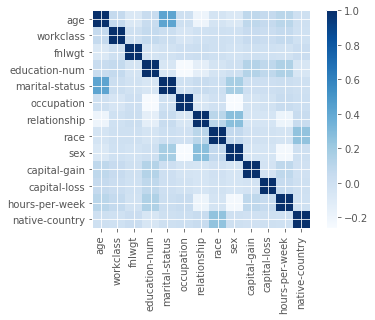

In [9]:
# Showing if there is any important correlation between variables
plt.imshow(X.corr(), cmap=plt.cm.Blues, interpolation='nearest')
plt.colorbar()
tick_marks = [i for i in range(len(X.columns))]
plt.xticks(tick_marks, X.columns, rotation='vertical')
plt.yticks(tick_marks, X.columns)

plt.show()
# We can see there are some logical correlations between marital-status and age, and between native-country and race.
# Something significant we didn't expect was the relationship between sex and relationship, but we are not going to dive into it because it is not meaningful for the purpose of this task
# If we look at capital-gain column, maybe the strongest correlation is with hours-per-week and education-num, but it is not significant

In [10]:
# If we look at how labels are distributed, we can see there are almost three times people who earns less than 50k rather than people who earns more than that.
y.value_counts()

0    33988
1    11206
Name: salary, dtype: int64

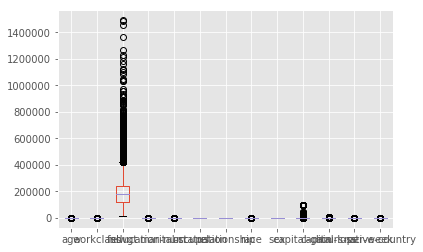

In [11]:
X.plot.box()
plt.show()

In [12]:
# Since data is not scaled because it doesn't have the same unit for every value, we have decided to remove columns that could take over the rest of data: fnlwgt, capital-gain and capital-loss
X = X.drop(['fnlwgt', 'capital-gain', 'capital-loss'], axis = 1)

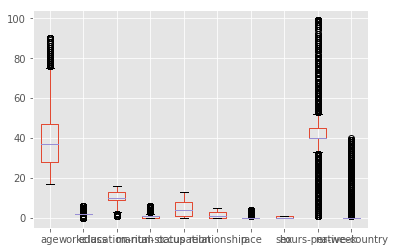

In [13]:
X.plot.box()
plt.show()

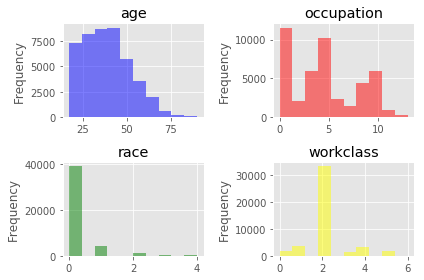

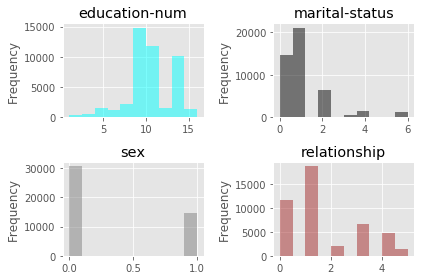

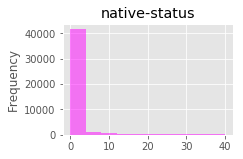

In [14]:
# We are taking a look at the distribution of all categorical features 
    # Looking at those distribution, we have seen for example race is will not be an important one in this dataset since most of samples are White. The same thing happends with workclass and native-country  

plt.subplot(2, 2, 1)
X['age'].plot.hist(alpha=0.5, color='blue')
plt.title('age')
plt.subplot(2, 2, 2) 
X['occupation'].plot.hist(alpha=0.5, color='red')
plt.title('occupation') 
plt.subplot(2, 2, 3) 
X['race'].plot.hist(alpha=0.5, color='green')
plt.title('race')
plt.subplot(2, 2, 4) 
X['workclass'].plot.hist(alpha=0.5, color='yellow')
plt.title('workclass')
plt.tight_layout()
plt.show()

plt.subplot(2, 2, 1)
X['education-num'].plot.hist(alpha=0.5, color='cyan')
plt.title('education-num')
plt.subplot(2, 2, 2) 
X['marital-status'].plot.hist(alpha=0.5, color='black')
plt.title('marital-status')
plt.subplot(2, 2, 3) 
X['sex'].plot.hist(alpha=0.5, color='grey')
plt.title('sex')
plt.tight_layout()
plt.subplot(2, 2, 4)  
X['relationship'].plot.hist(alpha=0.5, color='brown')
plt.title('relationship')
plt.tight_layout()
plt.show()

plt.subplot(2, 2, 1)
X['native-country'].plot.hist(alpha=0.5, color='magenta')
plt.title('native-status')
plt.tight_layout()
plt.show()

In [15]:
# TRAIN AND TEST SPLIT, holding out 30% of the dataset for testing after training.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

#### SCALING AND TRANSFORMATION

In [16]:
# Because of the features of the dataset have different units, we normalizing/standardizing (scaling) them. We have tried several methods:
# T = preprocessing.Normalizer().fit(X_train)
# T = preprocessing.StandardScaler().fit(X_train)
# T = preprocessing.MinMaxScaler().fit(X_train)
T = preprocessing.RobustScaler().fit(X_train)

# RobustScaler showed us a better score with KNN, so we have kept the whole exercise with this preprocessor method.

In [17]:
# With the trained pre-processor, we have transformed both training and testing data, so that it exist in the same feature-space as the original data used to train models.
X_train_p = T.transform(X_train)
X_test_p = T.transform(X_test)

In [18]:
# Because of the size of the dataset, we decided to transform it into an easier way to visualize space with PCA. It also gave us a faster way to process every model
# Since PCA is sensible to scaling feature, we have done preprocessing previously. Some of the features had more "weight" into the dataset because of the units they had.
pca = PCA(n_components=2, svd_solver='randomized')
pca.fit(X_train_p)

PCA_X_train = pca.transform(X_train_p)
PCA_X_test = pca.transform(X_test_p)

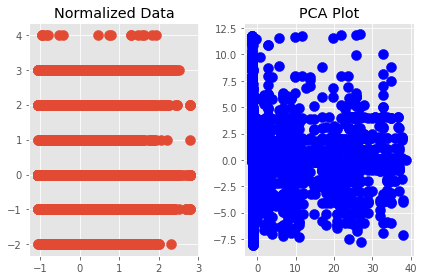

In [19]:
# This is just for visualizing how data has been transformed. When we did it with fnwlgt, this feature take control over all data, so we have decided to remove and this is the actual view without it.
plt.subplot(1, 2, 1)
plt.scatter(X_train_p[:,0], X_train_p[:,1], s=100)
plt.title('Normalized Data')
plt.subplot(1, 2, 2)
plt.scatter(PCA_X_train[:,0], PCA_X_train[:,1], s=100, color='blue')
plt.title('PCA Plot')
plt.tight_layout()
plt.show()

In [20]:
# Function declared to show us those previous plots into a 3D graphic 
def drawPlane(X_test, y_test, title):

    fig = plt.figure()
    ax = Axes3D(fig)
    ax.set_zlabel('prediction')

    
    # You might have passed in a DataFrame, a Series (slice),
    # an NDArray, or a Python List... so let's keep it simple:
    X_test = np.array(X_test)
    col1 = X_test[:,0]
    col2 = X_test[:,1]

    
    # Set up a Grid. We could have predicted on the actual
    # col1, col2 values directly; but that would have generated
    # a mesh with WAY too fine a grid, which would have detracted
    # from the visualization
    x_min, x_max = col1.min(), col1.max()
    y_min, y_max = col2.min(), col2.max()
    x = np.arange(x_min, x_max, (x_max-x_min) / 10)
    y = np.arange(y_min, y_max, (y_max-y_min) / 10)
    x, y = np.meshgrid(x, y)

    
    ax.scatter(col1, col2, y_test, s=100, c=['royalblue'], marker='o')

    ax.set_title(title)

    plt.show()

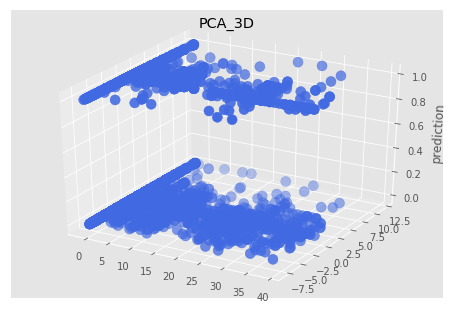

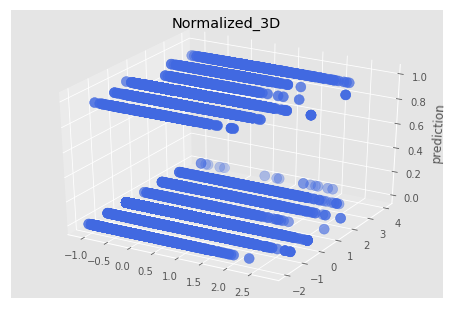

In [21]:
# 3D representation to show how the really are scattered
drawPlane(PCA_X_train, y_train, "PCA_3D")
drawPlane(X_train_p, y_train, 'Normalized_3D')

n: 1 score: 0.771074563021
n: 2 score: 0.794601371783
n: 3 score: 0.798067704108
n: 4 score: 0.80367283723
n: 5 score: 0.806991666052
n: 6 score: 0.812965557932
n: 7 score: 0.811638026403
n: 8 score: 0.8137768272
n: 9 score: 0.813850578951
n: 10 score: 0.817316911277
n: 11 score: 0.815030606977
n: 12 score: 0.818275684047
n: 13 score: 0.817759421786
n: 14 score: 0.820414484844
n: 15 score: 0.817906925289
n: 16 score: 0.819898222583
n: 17 score: 0.819824470831
n: 18 score: 0.820414484844
n: 19 score: 0.819676967328
max score find with KNN: 0.820414484844


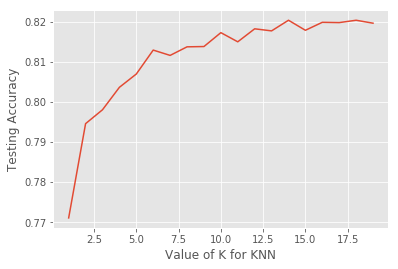

In [22]:
# Now, we try different hyperparameter using the hold-out simple method between differents n_neighbors settings.
# We have used this chunk of code for knowing which preprocessor works better with this dataset. Here we got that RobustScale and turning down PCA methods works better 
# We have also realized how faster it worked when using PCA transformation but with worse results.

scores = []
knn_n = np.arange(1, 20)
for i in knn_n:
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train_p, y_train)
    y_pred = knn.predict(X_test_p)
    scores.append(metrics.accuracy_score(y_test, y_pred))
    print('n: %s' % i, 'score: %s' % metrics.accuracy_score(y_test, y_pred))

print('max score find with KNN: %s' % max(scores))

plt.plot(knn_n, scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing Accuracy')
plt.show()

# The score increased from 0.80 to 0.82 when using preprocessing instead of using directly the train set.
# The score decreased from 0.8204 when using only preprocessing to 0.783 when using together with PCA methods. Nevertheless, it is much faster.

In [23]:
# Comparing hold-out with cross-validation method
# Hold-out method for n_neighbors=18:
knn_opt = KNeighborsClassifier(n_neighbors=18)
cvs = cross_val_score(knn_opt, X_train_p, y_train, cv=10)
print("Mean accuracy: " + str(np.mean(cvs)))
print("Std: " + str(np.std(cvs)))


Mean accuracy: 0.820990272959
Std: 0.0066775128047


In [24]:
# Cross validation method
knn_cv = KNeighborsClassifier()
cvs_cv = cross_val_score(knn_cv, X_train_p, y_train, cv=10)
print("Mean accuracy: " + str(np.mean(cvs_cv)))
print("Std: " + str(np.std(cvs_cv)))

Mean accuracy: 0.809231624203
Std: 0.00970964664361


In [97]:
# hold-out for n_neighbors = 18 worked better than cross-validation did

#### MODELING AND TUNING

In [32]:
# Setting up different parameters-grids for power-tuning every models:
    # KNN n_neighbors is recommended to use odd values when doing binary classification as it is, but we have use 18 and 20 to see how it behave
    # weights indicate how to count the votes from the neighbors (weighted vote)
    # metric: an optimization method for searching through your training data set to find the nearest neighbors
knn_param = {'n_neighbors': [3,5,7,9,11,13,15,18,20],'weights':['uniform','distance'], 'metric':['euclidean', 'manhattan', 'minkowski']}
    # Kernel "trick" is the way it can position decision boundaries optimally 
    # C is the penalty parameter for the error term, the lower C value, the smoother and more generalized decision boundary is going to be, the larger C value, the better it will work
    # gamma tells how pronounced the decision boundary is by varying the influence of the support vector samples. Smaller values, larger area. Larger values, more localized effects.
svc_param = {'kernel':('linear', 'rbf'), 'C': [1, 5, 10], 'gamma': [0.001, 0.01]} 
    # depth means the number of levels it will have
    # criterion is an impurity rating
    # splitter lets control of the algorithm chooses the best split or not.
dtree_param = {'max_depth': [3, 4, 5, 6, 7, 8, 9, 10], 'criterion': ['entropy', 'gini'], 'splitter': ['best', 'random']}
    # n_estimators controls de density of the randome forest
    # max_depth has the same meaning as decision trees
rfc_param = {'n_estimators': [10, 15, 20, 25, 30], 'max_depth': [3, 4, 5, 6, 7, 8]}

In [35]:
# MODELING
# KNN
knn = KNeighborsClassifier()
knn_gs = GridSearchCV(knn, knn_param, cv=10,verbose=2)
knn_gs.fit(X_train_p, y_train) 

Fitting 10 folds for each of 54 candidates, totalling 540 fits
[CV] metric=euclidean, n_neighbors=3, weights=uniform ................
[CV] . metric=euclidean, n_neighbors=3, weights=uniform, total=   1.2s
[CV] metric=euclidean, n_neighbors=3, weights=uniform ................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.0s remaining:    0.0s


[CV] . metric=euclidean, n_neighbors=3, weights=uniform, total=   1.2s
[CV] metric=euclidean, n_neighbors=3, weights=uniform ................
[CV] . metric=euclidean, n_neighbors=3, weights=uniform, total=   1.2s
[CV] metric=euclidean, n_neighbors=3, weights=uniform ................
[CV] . metric=euclidean, n_neighbors=3, weights=uniform, total=   1.1s
[CV] metric=euclidean, n_neighbors=3, weights=uniform ................
[CV] . metric=euclidean, n_neighbors=3, weights=uniform, total=   1.1s
[CV] metric=euclidean, n_neighbors=3, weights=uniform ................
[CV] . metric=euclidean, n_neighbors=3, weights=uniform, total=   1.2s
[CV] metric=euclidean, n_neighbors=3, weights=uniform ................
[CV] . metric=euclidean, n_neighbors=3, weights=uniform, total=   1.2s
[CV] metric=euclidean, n_neighbors=3, weights=uniform ................
[CV] . metric=euclidean, n_neighbors=3, weights=uniform, total=   1.2s
[CV] metric=euclidean, n_neighbors=3, weights=uniform ................
[CV] .

[CV]  metric=euclidean, n_neighbors=7, weights=distance, total=   1.2s
[CV] metric=euclidean, n_neighbors=9, weights=uniform ................
[CV] . metric=euclidean, n_neighbors=9, weights=uniform, total=   1.2s
[CV] metric=euclidean, n_neighbors=9, weights=uniform ................
[CV] . metric=euclidean, n_neighbors=9, weights=uniform, total=   1.2s
[CV] metric=euclidean, n_neighbors=9, weights=uniform ................
[CV] . metric=euclidean, n_neighbors=9, weights=uniform, total=   1.2s
[CV] metric=euclidean, n_neighbors=9, weights=uniform ................
[CV] . metric=euclidean, n_neighbors=9, weights=uniform, total=   1.2s
[CV] metric=euclidean, n_neighbors=9, weights=uniform ................
[CV] . metric=euclidean, n_neighbors=9, weights=uniform, total=   1.2s
[CV] metric=euclidean, n_neighbors=9, weights=uniform ................
[CV] . metric=euclidean, n_neighbors=9, weights=uniform, total=   1.2s
[CV] metric=euclidean, n_neighbors=9, weights=uniform ................
[CV] .

[CV]  metric=euclidean, n_neighbors=13, weights=distance, total=   1.2s
[CV] metric=euclidean, n_neighbors=13, weights=distance ..............
[CV]  metric=euclidean, n_neighbors=13, weights=distance, total=   1.2s
[CV] metric=euclidean, n_neighbors=13, weights=distance ..............
[CV]  metric=euclidean, n_neighbors=13, weights=distance, total=   1.2s
[CV] metric=euclidean, n_neighbors=15, weights=uniform ...............
[CV]  metric=euclidean, n_neighbors=15, weights=uniform, total=   1.2s
[CV] metric=euclidean, n_neighbors=15, weights=uniform ...............
[CV]  metric=euclidean, n_neighbors=15, weights=uniform, total=   1.2s
[CV] metric=euclidean, n_neighbors=15, weights=uniform ...............
[CV]  metric=euclidean, n_neighbors=15, weights=uniform, total=   1.2s
[CV] metric=euclidean, n_neighbors=15, weights=uniform ...............
[CV]  metric=euclidean, n_neighbors=15, weights=uniform, total=   1.3s
[CV] metric=euclidean, n_neighbors=15, weights=uniform ...............
[CV

[CV]  metric=euclidean, n_neighbors=20, weights=distance, total=   3.2s
[CV] metric=euclidean, n_neighbors=20, weights=distance ..............
[CV]  metric=euclidean, n_neighbors=20, weights=distance, total=   1.5s
[CV] metric=euclidean, n_neighbors=20, weights=distance ..............
[CV]  metric=euclidean, n_neighbors=20, weights=distance, total=   1.5s
[CV] metric=euclidean, n_neighbors=20, weights=distance ..............
[CV]  metric=euclidean, n_neighbors=20, weights=distance, total=   1.3s
[CV] metric=euclidean, n_neighbors=20, weights=distance ..............
[CV]  metric=euclidean, n_neighbors=20, weights=distance, total=   1.3s
[CV] metric=manhattan, n_neighbors=3, weights=uniform ................
[CV] . metric=manhattan, n_neighbors=3, weights=uniform, total=   1.2s
[CV] metric=manhattan, n_neighbors=3, weights=uniform ................
[CV] . metric=manhattan, n_neighbors=3, weights=uniform, total=   1.5s
[CV] metric=manhattan, n_neighbors=3, weights=uniform ................
[

[CV]  metric=manhattan, n_neighbors=7, weights=distance, total=   1.2s
[CV] metric=manhattan, n_neighbors=7, weights=distance ...............
[CV]  metric=manhattan, n_neighbors=7, weights=distance, total=   1.3s
[CV] metric=manhattan, n_neighbors=7, weights=distance ...............
[CV]  metric=manhattan, n_neighbors=7, weights=distance, total=   1.2s
[CV] metric=manhattan, n_neighbors=7, weights=distance ...............
[CV]  metric=manhattan, n_neighbors=7, weights=distance, total=   1.3s
[CV] metric=manhattan, n_neighbors=7, weights=distance ...............
[CV]  metric=manhattan, n_neighbors=7, weights=distance, total=   1.3s
[CV] metric=manhattan, n_neighbors=7, weights=distance ...............
[CV]  metric=manhattan, n_neighbors=7, weights=distance, total=   1.3s
[CV] metric=manhattan, n_neighbors=7, weights=distance ...............
[CV]  metric=manhattan, n_neighbors=7, weights=distance, total=   1.2s
[CV] metric=manhattan, n_neighbors=9, weights=uniform ................
[CV] .

[CV]  metric=manhattan, n_neighbors=13, weights=distance, total=   1.4s
[CV] metric=manhattan, n_neighbors=13, weights=distance ..............
[CV]  metric=manhattan, n_neighbors=13, weights=distance, total=   1.3s
[CV] metric=manhattan, n_neighbors=13, weights=distance ..............
[CV]  metric=manhattan, n_neighbors=13, weights=distance, total=   1.3s
[CV] metric=manhattan, n_neighbors=13, weights=distance ..............
[CV]  metric=manhattan, n_neighbors=13, weights=distance, total=   1.3s
[CV] metric=manhattan, n_neighbors=13, weights=distance ..............
[CV]  metric=manhattan, n_neighbors=13, weights=distance, total=   1.3s
[CV] metric=manhattan, n_neighbors=13, weights=distance ..............
[CV]  metric=manhattan, n_neighbors=13, weights=distance, total=   1.3s
[CV] metric=manhattan, n_neighbors=13, weights=distance ..............
[CV]  metric=manhattan, n_neighbors=13, weights=distance, total=   1.3s
[CV] metric=manhattan, n_neighbors=13, weights=distance ..............

[CV]  metric=manhattan, n_neighbors=20, weights=uniform, total=   1.4s
[CV] metric=manhattan, n_neighbors=20, weights=distance ..............
[CV]  metric=manhattan, n_neighbors=20, weights=distance, total=   1.4s
[CV] metric=manhattan, n_neighbors=20, weights=distance ..............
[CV]  metric=manhattan, n_neighbors=20, weights=distance, total=   1.4s
[CV] metric=manhattan, n_neighbors=20, weights=distance ..............
[CV]  metric=manhattan, n_neighbors=20, weights=distance, total=   1.4s
[CV] metric=manhattan, n_neighbors=20, weights=distance ..............
[CV]  metric=manhattan, n_neighbors=20, weights=distance, total=   1.4s
[CV] metric=manhattan, n_neighbors=20, weights=distance ..............
[CV]  metric=manhattan, n_neighbors=20, weights=distance, total=   1.4s
[CV] metric=manhattan, n_neighbors=20, weights=distance ..............
[CV]  metric=manhattan, n_neighbors=20, weights=distance, total=   1.4s
[CV] metric=manhattan, n_neighbors=20, weights=distance ..............


[CV] . metric=minkowski, n_neighbors=7, weights=uniform, total=   1.2s
[CV] metric=minkowski, n_neighbors=7, weights=uniform ................
[CV] . metric=minkowski, n_neighbors=7, weights=uniform, total=   1.2s
[CV] metric=minkowski, n_neighbors=7, weights=uniform ................
[CV] . metric=minkowski, n_neighbors=7, weights=uniform, total=   1.2s
[CV] metric=minkowski, n_neighbors=7, weights=distance ...............
[CV]  metric=minkowski, n_neighbors=7, weights=distance, total=   1.2s
[CV] metric=minkowski, n_neighbors=7, weights=distance ...............
[CV]  metric=minkowski, n_neighbors=7, weights=distance, total=   1.2s
[CV] metric=minkowski, n_neighbors=7, weights=distance ...............
[CV]  metric=minkowski, n_neighbors=7, weights=distance, total=   1.2s
[CV] metric=minkowski, n_neighbors=7, weights=distance ...............
[CV]  metric=minkowski, n_neighbors=7, weights=distance, total=   1.2s
[CV] metric=minkowski, n_neighbors=7, weights=distance ...............
[CV]  

[CV]  metric=minkowski, n_neighbors=13, weights=uniform, total=   1.2s
[CV] metric=minkowski, n_neighbors=13, weights=uniform ...............
[CV]  metric=minkowski, n_neighbors=13, weights=uniform, total=   1.2s
[CV] metric=minkowski, n_neighbors=13, weights=uniform ...............
[CV]  metric=minkowski, n_neighbors=13, weights=uniform, total=   1.2s
[CV] metric=minkowski, n_neighbors=13, weights=uniform ...............
[CV]  metric=minkowski, n_neighbors=13, weights=uniform, total=   1.3s
[CV] metric=minkowski, n_neighbors=13, weights=uniform ...............
[CV]  metric=minkowski, n_neighbors=13, weights=uniform, total=   1.2s
[CV] metric=minkowski, n_neighbors=13, weights=distance ..............
[CV]  metric=minkowski, n_neighbors=13, weights=distance, total=   1.2s
[CV] metric=minkowski, n_neighbors=13, weights=distance ..............
[CV]  metric=minkowski, n_neighbors=13, weights=distance, total=   1.2s
[CV] metric=minkowski, n_neighbors=13, weights=distance ..............
[CV]

[CV]  metric=minkowski, n_neighbors=20, weights=uniform, total=   1.2s
[CV] metric=minkowski, n_neighbors=20, weights=uniform ...............
[CV]  metric=minkowski, n_neighbors=20, weights=uniform, total=   1.3s
[CV] metric=minkowski, n_neighbors=20, weights=uniform ...............
[CV]  metric=minkowski, n_neighbors=20, weights=uniform, total=   1.3s
[CV] metric=minkowski, n_neighbors=20, weights=uniform ...............
[CV]  metric=minkowski, n_neighbors=20, weights=uniform, total=   1.2s
[CV] metric=minkowski, n_neighbors=20, weights=uniform ...............
[CV]  metric=minkowski, n_neighbors=20, weights=uniform, total=   1.3s
[CV] metric=minkowski, n_neighbors=20, weights=uniform ...............
[CV]  metric=minkowski, n_neighbors=20, weights=uniform, total=   1.3s
[CV] metric=minkowski, n_neighbors=20, weights=uniform ...............
[CV]  metric=minkowski, n_neighbors=20, weights=uniform, total=   1.2s
[CV] metric=minkowski, n_neighbors=20, weights=distance ..............
[CV]  

[Parallel(n_jobs=1)]: Done 540 out of 540 | elapsed: 42.7min finished


GridSearchCV(cv=10, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [3, 5, 7, 9, 11, 13, 15, 18, 20], 'weights': ['uniform', 'distance'], 'metric': ['euclidean', 'manhattan', 'minkowski']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

In [36]:
# Comparing between best_score of the GridSearchCV in the train set and how this model behave with different data (test set)
knn_test_score = knn_gs.score(X_test_p, y_test) 
knn_gs_best_score = knn_gs.best_score_
print(knn_test_score)
print(knn_gs_best_score)

0.823290803157
0.824466571835


In [39]:
knn_gs.best_params_

{'metric': 'manhattan', 'n_neighbors': 18, 'weights': 'uniform'}

In [38]:
knn_opt = KNeighborsClassifier(metric='manhattan', n_neighbors=18, weights='uniform')
knn_opt.fit(X_train_p, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan',
           metric_params=None, n_jobs=1, n_neighbors=18, p=2,
           weights='uniform')

In [101]:
# We have compared CV score results and test score results with train score in every model to make an idea of how overfiting or underfiting is the model. 
knn_cvs = cross_val_score(knn, X_train_p, y_train, cv=10)

y_pred_knn = knn_opt.predict(X_test_p)
print('KNN model prediction accuracy: %s' % metrics.accuracy_score(y_test, y_pred_knn))
print("CV mean accuracy: " + str(np.mean(lgr_knn)))
print("CV Std: " + str(np.std(knn_cvs)))

KNN model prediction accuracy: 0.823290803157
CV mean accuracy: 0.82038963739
CV Std: 0.00749310344459


In [62]:
# Logistic Regression
lgr = linear_model.LogisticRegression()
lgr_cvs = cross_val_score(lgr, X_train_p, y_train, cv=10)

lgr.fit(X_train_p, y_train)
y_pred_log = lgr.predict(X_test_p)

print('LogReg prediction accuracy: %s' % metrics.accuracy_score(y_test, y_pred_log))
print("CV Mean accuracy: " + str(np.mean(lgr_cvs)))
print("CV Std: " + str(np.std(lgr_cvs)))

LogReg prediction accuracy: 0.800944022421
Mean accuracy: 0.794309571757
Std: 0.00816134692533


In [27]:
# SVC. We can't pass through GridSearchCV because it was always hanging the computer, maybe because of the amount of data and hardward limitations.
# So, we have done it as simple as we could
svc = SVC()
svc.fit(X_train_p, y_train)
svc.score(X_test_p, y_test)

0.82513459694667746

In [102]:
svc_cvs = cross_val_score(svc, X_train_p, y_train, cv=10)

y_pred_svc = svc.predict(X_test_p)
print('SVC model prediction accuracy: %s' % metrics.accuracy_score(y_test, y_pred_svc))
print("CV mean accuracy: " + str(np.mean(svc_cvs)))
print("CV Std: " + str(np.std(svc_cvs)))

SVC model prediction accuracy: 0.825134596947
CV mean accuracy: 0.82152748761
CV Std: 0.00517396810773


In [106]:
# Decision Trees
dtree = DecisionTreeClassifier()
dtree_gs = GridSearchCV(dtree, dtree_param, cv=10, verbose=2)
dtree_gs.fit(X_train_p, y_train)
dtree_gs.score(X_test_p, y_test)

Fitting 10 folds for each of 32 candidates, totalling 320 fits
[CV] criterion=entropy, max_depth=3, splitter=best ...................
[CV] .... criterion=entropy, max_depth=3, splitter=best, total=   0.0s
[CV] criterion=entropy, max_depth=3, splitter=best ...................
[CV] .... criterion=entropy, max_depth=3, splitter=best, total=   0.0s
[CV] criterion=entropy, max_depth=3, splitter=best ...................
[CV] .... criterion=entropy, max_depth=3, splitter=best, total=   0.0s
[CV] criterion=entropy, max_depth=3, splitter=best ...................
[CV] .... criterion=entropy, max_depth=3, splitter=best, total=   0.0s
[CV] criterion=entropy, max_depth=3, splitter=best ...................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] .... criterion=entropy, max_depth=3, splitter=best, total=   0.0s
[CV] criterion=entropy, max_depth=3, splitter=best ...................
[CV] .... criterion=entropy, max_depth=3, splitter=best, total=   0.0s
[CV] criterion=entropy, max_depth=3, splitter=best ...................
[CV] .... criterion=entropy, max_depth=3, splitter=best, total=   0.0s
[CV] criterion=entropy, max_depth=3, splitter=best ...................
[CV] .... criterion=entropy, max_depth=3, splitter=best, total=   0.0s
[CV] criterion=entropy, max_depth=3, splitter=best ...................
[CV] .... criterion=entropy, max_depth=3, splitter=best, total=   0.0s
[CV] criterion=entropy, max_depth=3, splitter=best ...................
[CV] .... criterion=entropy, max_depth=3, splitter=best, total=   0.0s
[CV] criterion=entropy, max_depth=3, splitter=random .................
[CV] .. criterion=entropy, max_depth=3, splitter=random, total=   0.0s
[CV] criterion=entropy, max_depth=3, splitter=random .................
[CV] .

[CV] .... criterion=entropy, max_depth=6, splitter=best, total=   0.0s
[CV] criterion=entropy, max_depth=6, splitter=best ...................
[CV] .... criterion=entropy, max_depth=6, splitter=best, total=   0.0s
[CV] criterion=entropy, max_depth=6, splitter=best ...................
[CV] .... criterion=entropy, max_depth=6, splitter=best, total=   0.0s
[CV] criterion=entropy, max_depth=6, splitter=best ...................
[CV] .... criterion=entropy, max_depth=6, splitter=best, total=   0.0s
[CV] criterion=entropy, max_depth=6, splitter=best ...................
[CV] .... criterion=entropy, max_depth=6, splitter=best, total=   0.0s
[CV] criterion=entropy, max_depth=6, splitter=best ...................
[CV] .... criterion=entropy, max_depth=6, splitter=best, total=   0.0s
[CV] criterion=entropy, max_depth=6, splitter=best ...................
[CV] .... criterion=entropy, max_depth=6, splitter=best, total=   0.0s
[CV] criterion=entropy, max_depth=6, splitter=best ...................
[CV] .

[CV] .... criterion=entropy, max_depth=9, splitter=best, total=   0.1s
[CV] criterion=entropy, max_depth=9, splitter=best ...................
[CV] .... criterion=entropy, max_depth=9, splitter=best, total=   0.1s
[CV] criterion=entropy, max_depth=9, splitter=best ...................
[CV] .... criterion=entropy, max_depth=9, splitter=best, total=   0.1s
[CV] criterion=entropy, max_depth=9, splitter=best ...................
[CV] .... criterion=entropy, max_depth=9, splitter=best, total=   0.1s
[CV] criterion=entropy, max_depth=9, splitter=best ...................
[CV] .... criterion=entropy, max_depth=9, splitter=best, total=   0.1s
[CV] criterion=entropy, max_depth=9, splitter=best ...................
[CV] .... criterion=entropy, max_depth=9, splitter=best, total=   0.1s
[CV] criterion=entropy, max_depth=9, splitter=best ...................
[CV] .... criterion=entropy, max_depth=9, splitter=best, total=   0.1s
[CV] criterion=entropy, max_depth=9, splitter=best ...................
[CV] .

[CV] ....... criterion=gini, max_depth=4, splitter=best, total=   0.0s
[CV] criterion=gini, max_depth=4, splitter=best ......................
[CV] ....... criterion=gini, max_depth=4, splitter=best, total=   0.0s
[CV] criterion=gini, max_depth=4, splitter=best ......................
[CV] ....... criterion=gini, max_depth=4, splitter=best, total=   0.0s
[CV] criterion=gini, max_depth=4, splitter=best ......................
[CV] ....... criterion=gini, max_depth=4, splitter=best, total=   0.0s
[CV] criterion=gini, max_depth=4, splitter=best ......................
[CV] ....... criterion=gini, max_depth=4, splitter=best, total=   0.0s
[CV] criterion=gini, max_depth=4, splitter=best ......................
[CV] ....... criterion=gini, max_depth=4, splitter=best, total=   0.0s
[CV] criterion=gini, max_depth=4, splitter=random ....................
[CV] ..... criterion=gini, max_depth=4, splitter=random, total=   0.0s
[CV] criterion=gini, max_depth=4, splitter=random ....................
[CV] .

[CV] ....... criterion=gini, max_depth=7, splitter=best, total=   0.0s
[CV] criterion=gini, max_depth=7, splitter=best ......................
[CV] ....... criterion=gini, max_depth=7, splitter=best, total=   0.1s
[CV] criterion=gini, max_depth=7, splitter=best ......................
[CV] ....... criterion=gini, max_depth=7, splitter=best, total=   0.1s
[CV] criterion=gini, max_depth=7, splitter=best ......................
[CV] ....... criterion=gini, max_depth=7, splitter=best, total=   0.0s
[CV] criterion=gini, max_depth=7, splitter=best ......................
[CV] ....... criterion=gini, max_depth=7, splitter=best, total=   0.0s
[CV] criterion=gini, max_depth=7, splitter=random ....................
[CV] ..... criterion=gini, max_depth=7, splitter=random, total=   0.1s
[CV] criterion=gini, max_depth=7, splitter=random ....................
[CV] ..... criterion=gini, max_depth=7, splitter=random, total=   0.1s
[CV] criterion=gini, max_depth=7, splitter=random ....................
[CV] .

[CV] ...... criterion=gini, max_depth=10, splitter=best, total=   0.1s
[CV] criterion=gini, max_depth=10, splitter=best .....................
[CV] ...... criterion=gini, max_depth=10, splitter=best, total=   0.1s
[CV] criterion=gini, max_depth=10, splitter=best .....................
[CV] ...... criterion=gini, max_depth=10, splitter=best, total=   0.0s
[CV] criterion=gini, max_depth=10, splitter=best .....................
[CV] ...... criterion=gini, max_depth=10, splitter=best, total=   0.0s
[CV] criterion=gini, max_depth=10, splitter=best .....................
[CV] ...... criterion=gini, max_depth=10, splitter=best, total=   0.0s
[CV] criterion=gini, max_depth=10, splitter=best .....................
[CV] ...... criterion=gini, max_depth=10, splitter=best, total=   0.1s
[CV] criterion=gini, max_depth=10, splitter=best .....................
[CV] ...... criterion=gini, max_depth=10, splitter=best, total=   0.1s
[CV] criterion=gini, max_depth=10, splitter=random ...................
[CV] .

[Parallel(n_jobs=1)]: Done 320 out of 320 | elapsed:   15.6s finished


0.82638837672394716

In [117]:
dtree_gs.best_params_

{'criterion': 'entropy', 'max_depth': 8, 'splitter': 'best'}

In [118]:
dtree_opt = DecisionTreeClassifier(criterion='entropy', max_depth=8, splitter='best')
dtree_opt.fit(X_train_p, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=8,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [119]:
dt_cvs = cross_val_score(svc, X_train_p, y_train, cv=10)

y_pred_dt = dtree_opt.predict(X_test_p)
print('Decisiont Tree model prediction accuracy: %s' % metrics.accuracy_score(y_test, y_pred_dt))
print("CV mean accuracy: " + str(np.mean(dt_cvs)))
print("CV Std: " + str(np.std(dt_cvs)))

Decisiont Tree model prediction accuracy: 0.826388376724
CV mean accuracy: 0.82152748761
CV Std: 0.00517396810773


In [121]:
# Exporting decision tree schema (brunches) into a .png file. It can be seen in the tree.png file generated 
dtree_opt.fit(X_train, y_train)
tree.export_graphviz(dtree_opt, out_file='tree.dot', feature_names=X.columns) # It worked after deleting '.tree_'
call(['dot', '-T', 'png', 'tree.dot', '-o', 'tree.png'])

0

In [33]:
# Random Forest
rfc = RandomForestClassifier()
rfc_gs = GridSearchCV(rfc, rfc_param, cv=10, verbose=2)
rfc_gs.fit(X_train_p, y_train)
rfc_gs.score(X_test_p, y_test)

Fitting 10 folds for each of 30 candidates, totalling 300 fits
[CV] max_depth=3, n_estimators=10 ....................................
[CV] ..................... max_depth=3, n_estimators=10, total=   0.1s
[CV] max_depth=3, n_estimators=10 ....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] ..................... max_depth=3, n_estimators=10, total=   0.1s
[CV] max_depth=3, n_estimators=10 ....................................
[CV] ..................... max_depth=3, n_estimators=10, total=   0.1s
[CV] max_depth=3, n_estimators=10 ....................................
[CV] ..................... max_depth=3, n_estimators=10, total=   0.1s
[CV] max_depth=3, n_estimators=10 ....................................
[CV] ..................... max_depth=3, n_estimators=10, total=   0.1s
[CV] max_depth=3, n_estimators=10 ....................................
[CV] ..................... max_depth=3, n_estimators=10, total=   0.1s
[CV] max_depth=3, n_estimators=10 ....................................
[CV] ..................... max_depth=3, n_estimators=10, total=   0.1s
[CV] max_depth=3, n_estimators=10 ....................................
[CV] ..................... max_depth=3, n_estimators=10, total=   0.1s
[CV] max_depth=3, n_estimators=10 ....................................
[CV] .

[CV] ..................... max_depth=4, n_estimators=10, total=   0.1s
[CV] max_depth=4, n_estimators=15 ....................................
[CV] ..................... max_depth=4, n_estimators=15, total=   0.1s
[CV] max_depth=4, n_estimators=15 ....................................
[CV] ..................... max_depth=4, n_estimators=15, total=   0.1s
[CV] max_depth=4, n_estimators=15 ....................................
[CV] ..................... max_depth=4, n_estimators=15, total=   0.1s
[CV] max_depth=4, n_estimators=15 ....................................
[CV] ..................... max_depth=4, n_estimators=15, total=   0.1s
[CV] max_depth=4, n_estimators=15 ....................................
[CV] ..................... max_depth=4, n_estimators=15, total=   0.1s
[CV] max_depth=4, n_estimators=15 ....................................
[CV] ..................... max_depth=4, n_estimators=15, total=   0.2s
[CV] max_depth=4, n_estimators=15 ....................................
[CV] .

[CV] ..................... max_depth=5, n_estimators=15, total=   0.2s
[CV] max_depth=5, n_estimators=15 ....................................
[CV] ..................... max_depth=5, n_estimators=15, total=   0.1s
[CV] max_depth=5, n_estimators=15 ....................................
[CV] ..................... max_depth=5, n_estimators=15, total=   0.1s
[CV] max_depth=5, n_estimators=20 ....................................
[CV] ..................... max_depth=5, n_estimators=20, total=   0.2s
[CV] max_depth=5, n_estimators=20 ....................................
[CV] ..................... max_depth=5, n_estimators=20, total=   0.2s
[CV] max_depth=5, n_estimators=20 ....................................
[CV] ..................... max_depth=5, n_estimators=20, total=   0.2s
[CV] max_depth=5, n_estimators=20 ....................................
[CV] ..................... max_depth=5, n_estimators=20, total=   0.2s
[CV] max_depth=5, n_estimators=20 ....................................
[CV] .

[CV] ..................... max_depth=6, n_estimators=20, total=   0.3s
[CV] max_depth=6, n_estimators=20 ....................................
[CV] ..................... max_depth=6, n_estimators=20, total=   0.3s
[CV] max_depth=6, n_estimators=20 ....................................
[CV] ..................... max_depth=6, n_estimators=20, total=   0.2s
[CV] max_depth=6, n_estimators=20 ....................................
[CV] ..................... max_depth=6, n_estimators=20, total=   0.3s
[CV] max_depth=6, n_estimators=20 ....................................
[CV] ..................... max_depth=6, n_estimators=20, total=   0.3s
[CV] max_depth=6, n_estimators=25 ....................................
[CV] ..................... max_depth=6, n_estimators=25, total=   0.7s
[CV] max_depth=6, n_estimators=25 ....................................
[CV] ..................... max_depth=6, n_estimators=25, total=   0.3s
[CV] max_depth=6, n_estimators=25 ....................................
[CV] .

[CV] ..................... max_depth=7, n_estimators=25, total=   0.3s
[CV] max_depth=7, n_estimators=25 ....................................
[CV] ..................... max_depth=7, n_estimators=25, total=   0.3s
[CV] max_depth=7, n_estimators=25 ....................................
[CV] ..................... max_depth=7, n_estimators=25, total=   0.3s
[CV] max_depth=7, n_estimators=25 ....................................
[CV] ..................... max_depth=7, n_estimators=25, total=   0.3s
[CV] max_depth=7, n_estimators=25 ....................................
[CV] ..................... max_depth=7, n_estimators=25, total=   0.5s
[CV] max_depth=7, n_estimators=25 ....................................
[CV] ..................... max_depth=7, n_estimators=25, total=   0.3s
[CV] max_depth=7, n_estimators=25 ....................................
[CV] ..................... max_depth=7, n_estimators=25, total=   0.3s
[CV] max_depth=7, n_estimators=30 ....................................
[CV] .

[CV] ..................... max_depth=8, n_estimators=30, total=   0.4s
[CV] max_depth=8, n_estimators=30 ....................................
[CV] ..................... max_depth=8, n_estimators=30, total=   0.4s
[CV] max_depth=8, n_estimators=30 ....................................
[CV] ..................... max_depth=8, n_estimators=30, total=   0.4s
[CV] max_depth=8, n_estimators=30 ....................................
[CV] ..................... max_depth=8, n_estimators=30, total=   0.4s
[CV] max_depth=8, n_estimators=30 ....................................
[CV] ..................... max_depth=8, n_estimators=30, total=   0.4s
[CV] max_depth=8, n_estimators=30 ....................................
[CV] ..................... max_depth=8, n_estimators=30, total=   0.4s
[CV] max_depth=8, n_estimators=30 ....................................
[CV] ..................... max_depth=8, n_estimators=30, total=   0.4s
[CV] max_depth=8, n_estimators=30 ....................................
[CV] .

[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:  1.3min finished


0.82815841876244556

In [64]:
rf_cvs = cross_val_score(svc, X_train_p, y_train, cv=10)

y_pred_rf = rfc_gs.predict(X_test_p)
print('Random Forest model prediction accuracy: %s' % metrics.accuracy_score(y_test, y_pred_rf))
print("CV mean accuracy: " + str(np.mean(rf_cvs)))
print("CV Std: " + str(np.std(rf_cvs)))

SVC model prediction accuracy: 0.828158418762


In [68]:
# Naive Bayes
gnb = GaussianNB()
gnb_cvs = cross_val_score(gnb,X_train_p,y_train,cv=10)

gnb.fit(X_train_p, y_train)
y_pred_gnb = gnb.predict(X_test_p)

print('Naive Bayes prediction accuracy: %s' % metrics.accuracy_score(y_test, y_pred_gnb))
print("CV Mean: " + str(np.mean(gnb_cvs)))
print("CV Std: " + str(np.std(gnb_cvs)))

LogReg prediction accuracy: 0.755144184674
Mean: 0.755586810698
Std: 0.0064461001287


In [122]:
# Comparing results in the same place
print('KNN model prediction accuracy: %s' % metrics.accuracy_score(y_test, y_pred_knn))
print('LogReg prediction accuracy: %s' % metrics.accuracy_score(y_test, y_pred_log))
print('SVC model prediction accuracy: %s' % metrics.accuracy_score(y_test, y_pred_svc))
print('Decisiont Tree model prediction accuracy: %s' % metrics.accuracy_score(y_test, y_pred_dt))
print('Random Forest model prediction accuracy: %s' % metrics.accuracy_score(y_test, y_pred_rf))
print('Naive Bayes prediction accuracy: %s' % metrics.accuracy_score(y_test, y_pred_gnb))

KNN model prediction accuracy: 0.823290803157
LogReg prediction accuracy: 0.800944022421
SVC model prediction accuracy: 0.825134596947
Decisiont Tree model prediction accuracy: 0.826388376724
Random Forest model prediction accuracy: 0.828158418762
Naive Bayes prediction accuracy: 0.755144184674


Comparing those models we can see that Random Forest has the highest score accuracy value but we will dive into it taking a look at some ohter factors as precision reports and confusion matrix

#### PRECISION REPORTS

Taking these definitions:	
- True Positive: you predict something that in fact it is so it is the desired result.
- True Negative: you predict something is not that it is suppose to be and in fact it isn't, so it is also a good predicition result.
- False Positive: you predict something is what you think it was, but it is not.
- False Negative: you predict something is not what you think it wasn't, but it is.

Recall:
Calculate the recall score, or the ratio of true_positives / (true_positives + false_negatives):

F1:
The F1 Score is a weighted average of the precision and recall. Defined as 2 * (precision * recall) / (precision + recall), the best possible result is 1 and the worst possible score is 0:

Precision:
You can also calculated the precision score. It is defined very similarly: true_positives / (true_positives + false_positives)


In [96]:
target_names = ['<=50', '>50']
print(' KNN\n', metrics.classification_report(y_test, y_pred_knn, target_names=target_names))
print('\n LOGISTIC REGRESS\n ', metrics.classification_report(y_test, y_pred_log, target_names=target_names))
print('\n SVC \n ', metrics.classification_report(y_test, y_pred_svc, target_names=target_names))
print('\n DECISION TREE \n ', metrics.classification_report(y_test, y_pred_dt, target_names=target_names))
print('\n RANDOM FOREST\n ', metrics.classification_report(y_test, y_pred_rf, target_names=target_names))
print('\n NAIVE BAYES\n ', metrics.classification_report(y_test, y_pred_gnb, target_names=target_names))

 KNN
              precision    recall  f1-score   support

       <=50       0.86      0.91      0.89     10305
        >50       0.66      0.54      0.60      3254

avg / total       0.81      0.82      0.82     13559


 LOGISTIC REGRESS
               precision    recall  f1-score   support

       <=50       0.83      0.93      0.88     10305
        >50       0.64      0.40      0.49      3254

avg / total       0.78      0.80      0.78     13559


 SVC 
               precision    recall  f1-score   support

       <=50       0.85      0.94      0.89     10305
        >50       0.70      0.47      0.57      3254

avg / total       0.81      0.83      0.81     13559


 DECISION TREE 
               precision    recall  f1-score   support

       <=50       0.88      0.89      0.89     10305
        >50       0.64      0.62      0.63      3254

avg / total       0.82      0.83      0.83     13559


 RANDOM FOREST
               precision    recall  f1-score   support

       <=50  

In general, we can see how model behave better with '<=50k' than with '>50k'
We will see it better with matrices

#### CONFUSION MATRICES

In [79]:
confusion_knn = metrics.confusion_matrix(y_test, y_pred_knn)
confusion_log = metrics.confusion_matrix(y_test, y_pred_log)
confusion_svc = metrics.confusion_matrix(y_test, y_pred_svc)
confusion_dt = metrics.confusion_matrix(y_test, y_pred_dt)
confusion_rf = metrics.confusion_matrix(y_test, y_pred_rf)
confusion_gnb = metrics.confusion_matrix(y_test, y_pred_gnb)

In [92]:
print(' KNN\n ', confusion_knn)
print('\n LOGISTIC REGRESS\n ', confusion_log)
print('\n SVC \n ', confusion_svc)
print('\n DECISION TREE \n ', confusion_dt)
print('\n RANDOM FOREST\n ', confusion_rf)
print('\n NAIVE BAYES\n ', confusion_gnb)

 KNN
  [[9394  911]
 [1485 1769]]

 LOGISTIC REGRESS
  [[9571  734]
 [1965 1289]]

 SVC 
  [[9647  658]
 [1713 1541]]

 DECISION TREE 
  [[9193 1112]
 [1242 2012]]

 RANDOM FOREST
  [[9684  621]
 [1709 1545]]

 NAIVE BAYES
  [[7813 2492]
 [ 828 2426]]


In [74]:
columns = ['<=50', '>50']

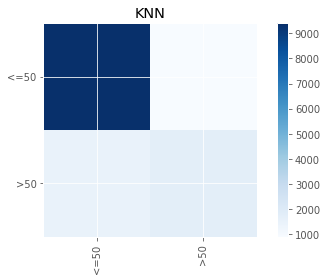

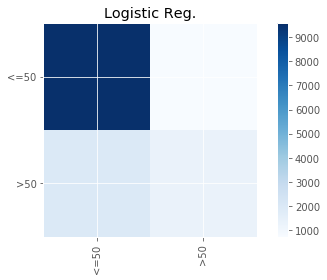

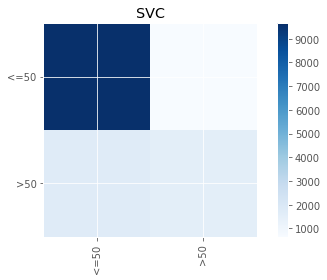

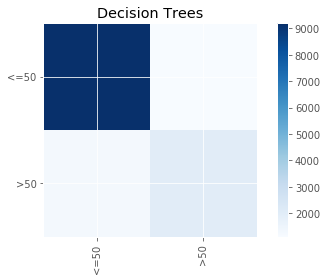

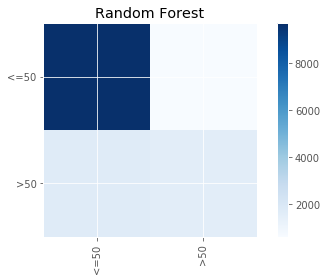

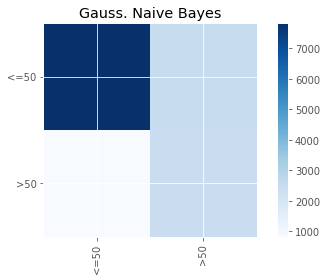

In [95]:
# Visual representation of matrices
plt.imshow(confusion_knn, cmap=plt.cm.Blues, interpolation='nearest')
plt.xticks([0,1], columns, rotation='vertical')
plt.yticks([0,1], columns)
plt.colorbar()
plt.title('KNN')
plt.tight_layout()
plt.show()

plt.imshow(confusion_log, cmap=plt.cm.Blues, interpolation='nearest')
plt.xticks([0,1], columns, rotation='vertical')
plt.yticks([0,1], columns)
plt.colorbar()
plt.title('Logistic Reg.')
plt.tight_layout()
plt.show()

plt.imshow(confusion_svc, cmap=plt.cm.Blues, interpolation='nearest')
plt.xticks([0,1], columns, rotation='vertical')
plt.yticks([0,1], columns)
plt.colorbar()
plt.title('SVC')
plt.tight_layout()
plt.show()

plt.imshow(confusion_dt, cmap=plt.cm.Blues, interpolation='nearest')
plt.xticks([0,1], columns, rotation='vertical')
plt.yticks([0,1], columns)
plt.colorbar()
plt.title('Decision Trees')
plt.tight_layout()
plt.show()

plt.imshow(confusion_rf, cmap=plt.cm.Blues, interpolation='nearest')
plt.xticks([0,1], columns, rotation='vertical')
plt.yticks([0,1], columns)
plt.colorbar()
plt.title('Random Forest')
plt.tight_layout()
plt.show()

plt.imshow(confusion_gnb, cmap=plt.cm.Blues, interpolation='nearest')
plt.xticks([0,1], columns, rotation='vertical')
plt.yticks([0,1], columns)
plt.colorbar()
plt.title('Gauss. Naive Bayes')
plt.tight_layout()
plt.show()

We can see how Random Forest predicts better the '<=50k', but the best approach is Randome Forest, since it works quite good (or better than the rest) with predicting both targets ouptputs